In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from os.path import join as pjoin
import scipy
from tvb.simulator.models.stefanescu_jirsa import ReducedSetHindmarshRose
from tvb.simulator.lab import *
from statannotations.Annotator import Annotator

In [10]:
# for test
file = pjoin('/Users/yilewang/Documents/K21_explore', 'SNC', "4849A_0.1.csv")
raw_sim_fmri = pd.read_csv(file,header=0)
s_corr = raw_sim_fmri.corr()

### Workflow

In [11]:
data_dir = '/Users/yilewang/workspaces/data4project/'
ts_dir = pjoin(data_dir, 'lateralization/ts_fmri/fmri_AAL_16/')
connectome_dir = pjoin(data_dir, 'lateralization/connectome/zip')
# read mega_table
mega_table = pd.read_excel(pjoin(data_dir, 'mega_table.xlsx'), sheet_name='hodgepodge', skiprows=1)

In [12]:
def tvb_K21_fitting(k21, Go, file):
    connectivity.speed = np.array([10.])
    sim = simulator.Simulator(
        model=ReducedSetHindmarshRose(K21=np.array([k21])), 
        connectivity=connectivity.Connectivity.from_file(file),                      
        coupling=coupling.Linear(a=np.array([Go])),
        simulation_length=1e3*416,
        integrator=integrators.HeunStochastic(dt=0.01220703125, noise=noise.Additive(nsig=np.array([1.0]), ntau=0.0,
                                                                                    random_stream=np.random.RandomState(seed=42))),
        monitors=(
        monitors.TemporalAverage(period=1.),
        monitors.Bold(hrf_kernel = equations.Gamma(), period=2000.),
        monitors.ProgressLogger(period=1e2)
        ))
    sim.configure()
    (tavg_time, tavg_data), (raw_time, raw_data),_ = sim.run()
    return raw_data

In [18]:
K21_range = np.arange(0.1, 3.1, 0.1)
_K21_range = [str(round(i, 1)) for i in K21_range]
# create a dataframe to store the correlation by each K21
corr_df = pd.DataFrame()

In [19]:
for case, grp, go in zip(mega_table['caseid'][:74], mega_table['group'][:74], mega_table['Go'][:74]):
    K21_corr = []
    
    for K21 in K21_range:
        K21 = np.round(K21, 1)
        file = pjoin('/Users/yilewang/Documents/K21_explore', grp, f"{case}_{format(K21, '.1f')}.csv")
        try:
            raw_sim_fmri = pd.read_csv(file, header=0)
        except:
            raw_data = tvb_K21_fitting(K21, go, pjoin(connectome_dir, grp, f"{case}.zip"))
            raw_data_mean = np.mean(raw_data, axis=3)
            raw_sim_fmri = pd.DataFrame(raw_data_mean[:,0,:], columns = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R'])
            raw_sim_fmri.to_csv(file, index=False)
        s_corr = raw_sim_fmri.corr()
        # read mat file
        mat = scipy.io.loadmat(pjoin(ts_dir, grp+"-TS", case, f"ROISignals_{case}.mat"))
        roi_signal = mat['ROISignals']
        df_roi = pd.DataFrame(roi_signal, columns = ['aCNG-L', 'aCNG-R','mCNG-L','mCNG-R','pCNG-L','pCNG-R', 'HIP-L','HIP-R','PHG-L','PHG-R','AMY-L','AMY-R', 'sTEMp-L','sTEMP-R','mTEMp-L','mTEMp-R'])
        e_corr = df_roi.corr()

        # take the top triangle of the matrix using triu
        e_corr = np.triu(e_corr, k=1)
        s_corr = np.triu(s_corr, k=1)

        # calculate the correlation of the two matrices
        s_corr = s_corr.flatten()
        e_corr = e_corr.flatten()
        # pearson correlation of two flattened matrices
        corr_pearson = np.corrcoef(s_corr, e_corr)[0,1]
        K21_corr.append(corr_pearson)
    single_pd = pd.DataFrame([K21_corr], columns=_K21_range)
    single_pd['case'] = case
    single_pd['group'] = grp
    corr_df = pd.concat([corr_df, single_pd], axis=0)

    # plt.plot(K21_range, K21_corr)
    # plt.title(f"{case} {grp} {K21_range[np.argmax(K21_corr)]} {np.round(K21_corr[np.argmax(K21_corr)],2)}")
    # plt.show()

In [22]:
# corr_df.to_excel('./corr_df.xlsx', index=False)
# find max correlation for each case in G
corr_df['max_corr'] = corr_df.iloc[:, :-2].max(axis=1)
# find max correlation corresoinding K21 in column
corr_df['K21'] = corr_df.iloc[:, :-3].idxmax(axis=1)


/var/folders/3n/xjq3mj2x4fg20l17q5mydc1c0000gn/T/ipykernel_10908/3926713562.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  corr_df['max_corr'] = corr_df.iloc[:, :-2].max(axis=1)


In [ ]:
corr_df.to_excel('./corr_df.xlsx', index=False)

Text(0.5, 1.0, 'Max correlation between simulated and empirical fMRI')

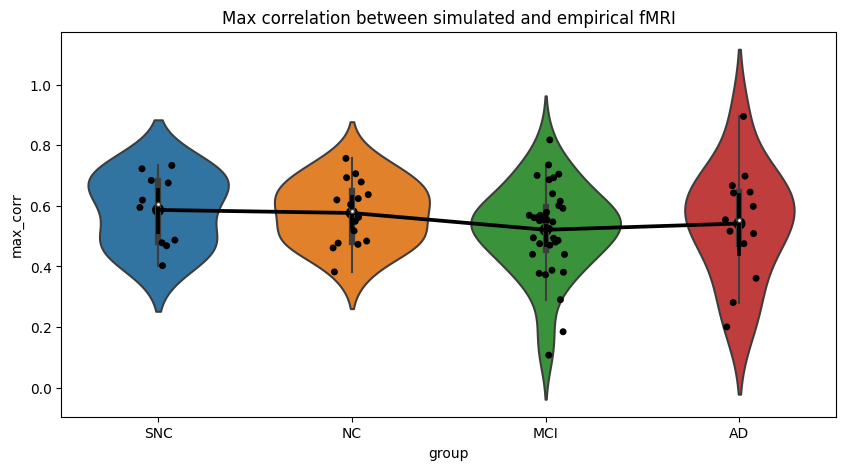

In [25]:
plt.figure(figsize=(10, 5))
sns.violinplot(x='group', y='max_corr', data=corr_df)
sns.stripplot(x='group', y='max_corr', data=corr_df, jitter=True, color='black')
sns.pointplot(x='group', y='max_corr', data=corr_df, color='black')
plt.title('Max correlation between simulated and empirical fMRI')

In [27]:
# convert corr_df["K21"] to float
corr_df["K21"] = corr_df["K21"].astype(float)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


(<Axes: title={'center': 'K21 value corresponding to max correlation'}, xlabel='group', ylabel='K21'>,
  <statannotations.Annotation.Annotation at 0x2b1a29990>])

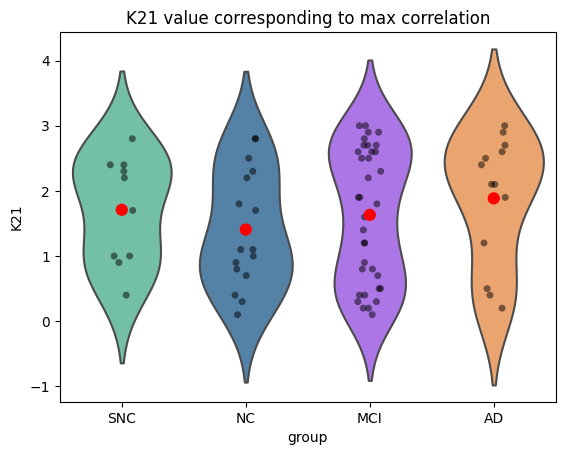

In [41]:
plt.figure()
ax1 = plt.subplot(111)
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
sns.violinplot(x="group", y='K21', data=corr_df, inner=None, palette=colors)
sns.stripplot(x="group", y='K21', data=corr_df, color='black', alpha=0.5,zorder=1)
sns.pointplot(x="group", y='K21', data=corr_df, color='r', ci=None, linestyles="")
plt.title('K21 value corresponding to max correlation')
annot = Annotator(pairs=[(("SNC"), ("NC")),(("SNC"), ("MCI")),(("SNC"), ("AD")), (("NC"), ("MCI")), (("MCI"),("AD"))],
            ax=ax1,
            x='group',
            y='K21',
            data=corr_df)
annot.configure(test='Mann-Whitney', text_format='star', comparisons_correction= "BH", hide_non_significant=True, correction_format="replace")
annot.apply_and_annotate()